In [311]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

Load Data Files

In [312]:
def load_data(file_path: str) -> pd.DataFrame:
    """Load data from a CSV file."""
    return pd.read_csv(file_path)

In [313]:
anime_base = load_data('../data/raw/anime-dataset-2025-2.csv')

watch_base_23 = load_data('../data/raw/users-score-2023.csv')
watch_base_25 = load_data('../data/raw/users-score-2025.csv')

In [314]:
print(f"Anime dataset 2025 (full) shape: {anime_base.shape}")

print(f"Watchlist 2023 shape: {watch_base_23.shape}")
print(f"Watchlist 2025 shape: {watch_base_25.shape}")

Anime dataset 2025 (full) shape: (29631, 26)
Watchlist 2023 shape: (24325191, 5)
Watchlist 2025 shape: (24928042, 5)


Fix column names in 2025 anime dataset

In [315]:
anime_base.rename(columns={'animeID': 'anime_id'}, inplace=True)

Remove unused columns

In [316]:
def filter_anime_data(anime_df: pd.DataFrame) -> pd.DataFrame:
    """Filter relevant columns from anime data."""
    new_df = anime_df[['anime_id', 'Name', 'Genres', 'Explicit Genres', 'Themes', 'Demographics', 'Type', 'Producers', 'Studios']]
    return new_df.set_index('anime_id')

def filter_watch_data(watch_df: pd.DataFrame) -> pd.DataFrame:
    """Filter relevant columns from watch data."""
    return watch_df[['user_id', 'anime_id', 'rating']]

In [317]:
anime_filtered = filter_anime_data(anime_base)

watch_filtered_23 = filter_watch_data(watch_base_23)
watch_filtered_25 = filter_watch_data(watch_base_25)

Remove anime ids from the watchlist, that are not in the anime dataset

In [318]:
all_unique_anime = set(watch_filtered_23['anime_id'].unique()).union(set(watch_filtered_25['anime_id'].unique()))
print("Total unique anime IDs watched across both years:", len(all_unique_anime))

Total unique anime IDs watched across both years: 25311


In [319]:
difference_anime = all_unique_anime.difference(anime_filtered.index)
print("Number of anime IDs in watchlists not present in anime dataset:", len(difference_anime))

Number of anime IDs in watchlists not present in anime dataset: 37


In [320]:
watch_reduced_23 = watch_filtered_23[watch_filtered_23['anime_id'].isin(anime_filtered.index)]
watch_reduced_25 = watch_filtered_25[watch_filtered_25['anime_id'].isin(anime_filtered.index)]

print(f"Number of entries removed from watchlist 2023: {watch_filtered_23.shape[0] - watch_reduced_23.shape[0]}")
print(f"Number of entries removed from watchlist 2025: {watch_filtered_25.shape[0] - watch_reduced_25.shape[0]}")

Number of entries removed from watchlist 2023: 3016
Number of entries removed from watchlist 2025: 0


Plot the user's watch list data

In [321]:
def calc_watch_counts(watch_df: pd.DataFrame) -> pd.Series:
    """Calculate the number of unique anime watched per user."""
    return watch_df.groupby('user_id')['anime_id'].nunique()

In [322]:
watch_count_23 = calc_watch_counts(watch_reduced_23)
watch_count_25 = calc_watch_counts(watch_reduced_25)

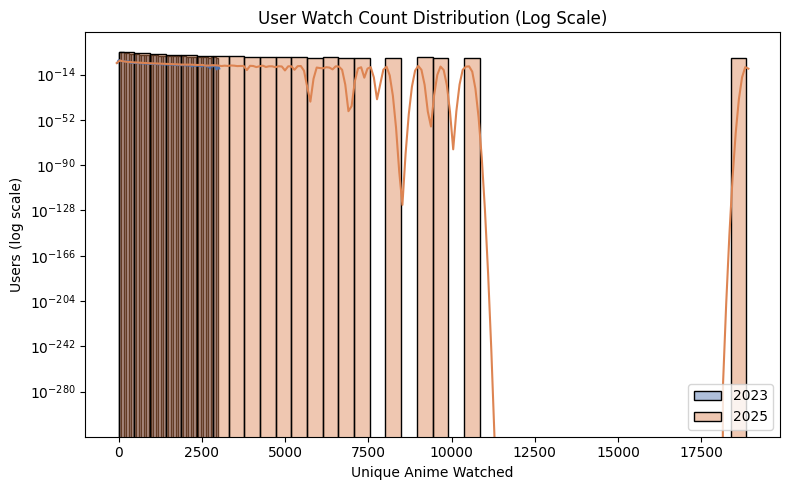

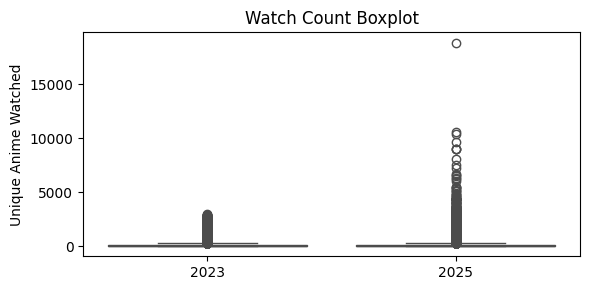

In [323]:
plt.figure(figsize=(8,5))
sns.histplot(watch_count_23, bins=40, color='#4C72B0', alpha=0.45, edgecolor='black', label='2023')
sns.histplot(watch_count_25, bins=40, color='#DD8452', alpha=0.45, edgecolor='black', label='2025')
sns.kdeplot(watch_count_23, color='#4C72B0')
sns.kdeplot(watch_count_25, color='#DD8452')
plt.yscale('log')
plt.xlabel('Unique Anime Watched')
plt.ylabel('Users (log scale)')
plt.title('User Watch Count Distribution (Log Scale)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
sns.boxplot(data=[watch_count_23.values, watch_count_25.values], palette=['#4C72B0', '#DD8452'])
plt.xticks([0,1], ['2023','2025'])
plt.ylabel('Unique Anime Watched')
plt.title('Watch Count Boxplot')
plt.tight_layout()
plt.show()

Distributions of the watch data

In [324]:
print(f"2023 Watchlist - Min: {watch_count_23.min()}, Max: {watch_count_23.max()}, Avg: {watch_count_23.mean():.2f}")
print(f"2025 Watchlist - Min: {watch_count_25.min()}, Max: {watch_count_25.max()}, Avg: {watch_count_25.mean():.2f}")

2023 Watchlist - Min: 1, Max: 2986, Avg: 90.07
2025 Watchlist - Min: 1, Max: 18857, Avg: 112.89


In [325]:
upper_23 = watch_count_23.quantile(0.99)

print(f"2023 Watchlist - Upper threshold: {upper_23}")

2023 Watchlist - Upper threshold: 646.7000000000116


Calculate and set boundaries for the watchlist datasets

In [326]:
lower_threshold, upper_threshold = 5, upper_23
print(f"Lower threshold for 2023: {lower_threshold}", f"Upper threshold for 2023: {upper_threshold}")

Lower threshold for 2023: 5 Upper threshold for 2023: 646.7000000000116


In [327]:
watch_boundary_23 = watch_reduced_23[watch_reduced_23['user_id'].isin(
    watch_count_23[(watch_count_23 >= lower_threshold) & (watch_count_23 <= upper_threshold)].index
)]

In [328]:
watch_boundary_25 = watch_reduced_25[watch_reduced_25['user_id'].isin(
    watch_count_25[(watch_count_25 <= upper_threshold)].index
)]

Let the 2025 dataset only contain users with a certain growth from 2025

In [329]:
def filter_common_users(data_1: pd.DataFrame, data_2: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Get watch data for users common to both years."""
    common_users = set(data_1['user_id']).intersection(set(data_2['user_id']))
    print(f"Number of common users: {len(common_users)}")
    data_1_common = data_1[data_1['user_id'].isin(common_users)]
    data_2_common = data_2[data_2['user_id'].isin(common_users)]
    return data_1_common, data_2_common

In [330]:
# Remove first users, then filter for common users after applying boundaries
watch_same_23, watch_same_25 = filter_common_users(watch_boundary_23, watch_boundary_25)

Number of common users: 100005


In [331]:
min_increase = lower_threshold

watch_count_23 = calc_watch_counts(watch_same_23)
watch_count_25 = calc_watch_counts(watch_same_25)

common_users = watch_count_23.index.intersection(watch_count_25.index)
delta = watch_count_25.loc[common_users] - watch_count_23.loc[common_users]
grown_users = delta[delta >= min_increase].index

watch_shrunk_23 = watch_same_23[watch_same_23['user_id'].isin(grown_users)]
watch_shrunk_25 = watch_same_25[watch_same_25['user_id'].isin(grown_users)]

print(f"Users with at least +{min_increase} unique anime: {len(grown_users)}")

Users with at least +5 unique anime: 10974


Print/Plot growth statistics

In [332]:
growth_counts = delta.loc[grown_users]
print("Minimum growth in watched anime count:", growth_counts.min())
print("Maximum growth in watched anime count:", growth_counts.max())
print("Average growth in watched anime count:", growth_counts.mean())

Minimum growth in watched anime count: 5
Maximum growth in watched anime count: 593
Average growth in watched anime count: 102.98496446145435


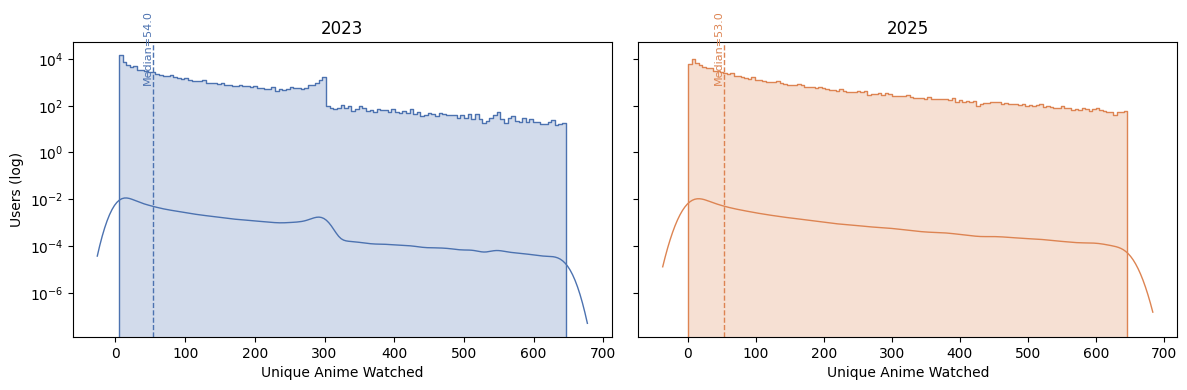

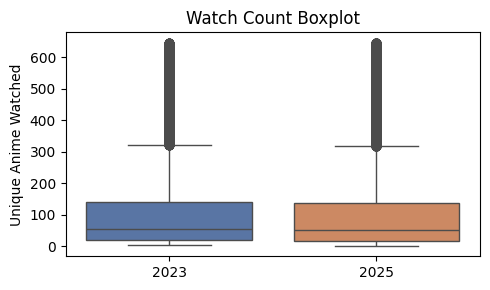

In [333]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
bins_23 = np.histogram_bin_edges(watch_count_23, bins='fd')  # Freedman–Diaconis
bins_25 = np.histogram_bin_edges(watch_count_25, bins='fd')

sns.histplot(watch_count_23, bins=bins_23, ax=axes[0], color='#4C72B0',
             edgecolor='#4C72B0', alpha=0.25, element='step')
sns.kdeplot(watch_count_23, ax=axes[0], color='#4C72B0', lw=1)
axes[0].set_yscale('log')
axes[0].set_title('2023')
axes[0].set_xlabel('Unique Anime Watched')
axes[0].set_ylabel('Users (log)')
m23 = watch_count_23.median()
axes[0].axvline(m23, color='#4C72B0', ls='--', lw=1)
axes[0].text(m23, axes[0].get_ylim()[1]*0.6, f'Median={m23}', rotation=90,
             va='center', ha='right', color='#4C72B0', fontsize=8)

sns.histplot(watch_count_25, bins=bins_25, ax=axes[1], color='#DD8452',
             edgecolor='#DD8452', alpha=0.25, element='step')
sns.kdeplot(watch_count_25, ax=axes[1], color='#DD8452', lw=1)
axes[1].set_yscale('log')
axes[1].set_title('2025')
axes[1].set_xlabel('Unique Anime Watched')
m25 = watch_count_25.median()
axes[1].axvline(m25, color='#DD8452', ls='--', lw=1)
axes[1].text(m25, axes[1].get_ylim()[1]*0.6, f'Median={m25}', rotation=90,
             va='center', ha='right', color='#DD8452', fontsize=8)

plt.tight_layout()
plt.show()

# Compact combined summary (optional)
plt.figure(figsize=(5,3))
sns.boxplot(data=[watch_count_23.values, watch_count_25.values],
            palette=['#4C72B0', '#DD8452'])
plt.xticks([0,1], ['2023','2025'])
plt.ylabel('Unique Anime Watched')
plt.title('Watch Count Boxplot')
plt.tight_layout()
plt.show()

Save as processed

In [334]:
def save_preprocessed_data(df: pd.DataFrame, file_path: str, index: bool) -> None:
    """Save preprocessed data to a CSV file."""
    df.to_csv(file_path, index=index)

In [335]:
save_preprocessed_data(anime_filtered, '../data/clean/anime-dataset-filtered.csv', True)

save_preprocessed_data(watch_shrunk_23, '../data/clean/users-score-shrunk-2023.csv', False)
save_preprocessed_data(watch_shrunk_25, '../data/clean/users-score-shrunk-2025.csv', False)